# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_(finance)).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use SFrames to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.


## sklearn / pandas version

In [245]:
import pandas as pd
import numpy as np
#pd.canvas.set_target('ipynb')
from __future__ import division  #ensures floating point division

import seaborn as sns
# see nice tutorial on seaborn
# https://stanford.edu/~mwaskom/software/seaborn/tutorial/categorical.html
import matplotlib.pyplot as plt
%matplotlib inline     

# Load LendingClub dataset

**1.** We will be using a dataset from the [LendingClub](https://www.lendingclub.com/). A parsed and cleaned form of the dataset is availiable [here](https://github.com/learnml/machine-learning-specialization-private). Make sure you **download the dataset** before running the following command.

In [246]:
loans = pd.read_csv('lending-club-data.csv')

## Exploring some features

**2.** Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [247]:
loans.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.3932,20161201T000000,1,1,1


Here, we see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc. Let's take a look at the distribution of loan grades in the dataset.

In [248]:
print "Features are ",loans.columns 
print "Number of features = %d" %len(loans.columns)
print "Number of samples = %d" %(loans.size/len(loans.columns))
print "Dimension of data frame=", loans.ndim
print "Indexing for samples=", loans.index
print "Number of samples/rows = %d and num of features/cols =  %d" %loans.shape
(num_rows,num_cols) = loans.shape  #shape returns tuple (num_rows,num_cols)
#print "Product columns data types", loans.dtypes

Features are  Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
       u'is_inc_v', u'issue_d', u'loan_status', u'pymnt_plan', u'url', u'desc',
       u'purpose', u'title', u'zip_code', u'addr_state', u'dti',
       u'delinq_2yrs', u'earliest_cr_line', u'inq_last_6mths',
       u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
       u'last_credit_pull_d', u'collections_12_mths_ex_med',
       u'mths_since_last_major_derog', u'policy_code', u'not_compliant',
       u'stat

In [249]:
pd.crosstab(index=loans['grade'],  # Make a crosstab
                  columns=['count'])      # Name the count column
                        #margins=True)   # Include row and column totals


col_0,count
grade,
A,22314
B,37172
C,29950
D,19175
E,8990
F,3932
G,1074


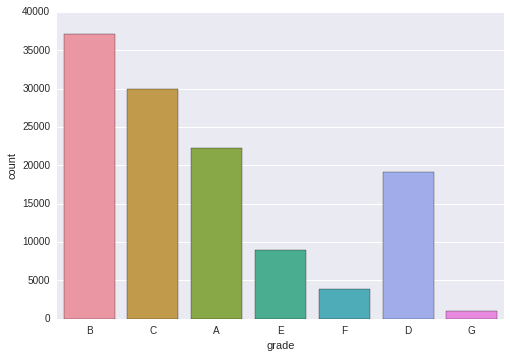

In [250]:
# import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="grade", data=loans)    

## crosstab
To get proportions: pd.crosstab(df.A, df.B).apply(lambda r: r/r.sum(), axis=1)

Basically you just have the function that does row/row.sum(), and you use apply with axis=1 to apply it by row.


If you're looking for a percentage of the total, you can divide by the len of the df instead of the row sum:

pd.crosstab(df.A, df.B).apply(lambda r: r/len(df), axis=1)

In [251]:
table_loan_grade = pd.crosstab(loans['grade'], # Make a crosstab
                    columns=['counts'])        # Name the count column
#                    margins=True)   # Include row and column totals

print table_loan_grade

table_loan_grade = pd.crosstab(loans['grade'],columns=['proportions']).apply(lambda r: r/len(loans), axis=0)

table_loan_grade 
#cross.apply(lambda r: r/r.sum(), axis=0)
#cross.apply(lambda r: r/len(loans), axis=0)

col_0  counts
grade        
A       22314
B       37172
C       29950
D       19175
E        8990
F        3932
G        1074


col_0,proportions
grade,
A,0.181996
B,0.303180
C,0.244276
D,0.156394
E,0.073324
F,0.032070
G,0.008760


In [252]:
pd.crosstab(loans.grade, loans.sub_grade)

sub_grade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,...,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
grade,,,,,,,,,,,,,,,,,,,,,
A,2987,3352,3955,5993,6027,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B,0,0,0,0,0,5837,7096,9036,8279,6924,...,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,0,0,...,1105,930,770,629,498,0,0,0,0,0
G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,370,241,167,152,144


We can see that over half of the loan grades are assigned values `B` or `C`. Each loan is assigned one of these grades, along with a more finely discretized feature called `sub_grade` (feel free to explore that feature column as well!). These values depend on the loan application and credit report, and determine the interest rate of the loan. More information can be found [here](https://www.lendingclub.com/public/rates-and-fees.action).

Now, let's look at "home_ownership" feature.

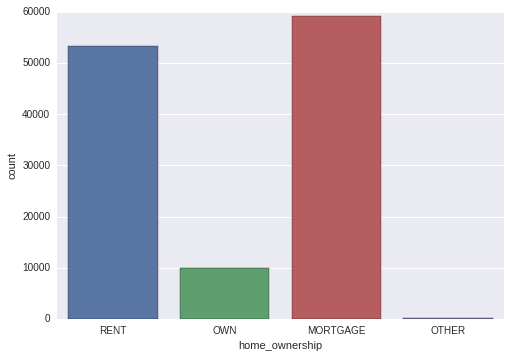

In [253]:
sns.countplot(x="home_ownership", data=loans) 

In [254]:
#loans['home_ownership'].show()
table_home_ownership =  pd.crosstab(loans.home_ownership, columns='counts')
table_home_ownership

col_0,counts
home_ownership,
MORTGAGE,59240
OTHER,179
OWN,9943
RENT,53245


This feature describes whether the loanee is mortaging, renting, or owns a home. We can see that a small percentage of the loanees own a home ~ 8%, majority are mortgagees ~48% or renting ~43%.

In [255]:
table_home_ownership =  pd.crosstab(loans.home_ownership, columns='percentages')
table_home_ownership.apply(lambda r: r*100/len(loans), axis=0)

col_0,percentages
home_ownership,
MORTGAGE,48.316980
OTHER,0.145995
OWN,8.109651
RENT,43.427374


## Exploring the target column

The target column (response label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

**3.** We create a new column called `safe_loans`, and store loan outcome there.

In [256]:
loans[['id', 'member_id', 'loan_amnt', 'bad_loans']].head(2)

,id,member_id,loan_amnt,bad_loans
0,1077501,1296599,5000,0
1,1077430,1314167,2500,1


In [257]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

# just check if conversion done properly, before removing the 'bad_loans' col
print loans[['id', 'member_id', 'loan_amnt', 'bad_loans', 'safe_loans']].head(2)

# removing row traightforward
# to remove/drop a column, axis=1 denotes that we are referring to a column
# see http://chrisalbon.com/python/pandas_dropping_column_and_rows.html

loans = loans.drop('bad_loans', axis=1)

        id  member_id  loan_amnt  bad_loans  safe_loans
0  1077501    1296599       5000          0           1
1  1077430    1314167       2500          1          -1


**4.** Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset. Print out the percentage of safe loans and risky loans in the data frame. seel also [frequency tables](http://hamelg.blogspot.com.au/2015/11/python-for-data-analysis-part-19_17.html). A frequency table is just a data table that shows the counts of one or more categorical variables. Create frequency tables (also known as crosstabs) in pandas using the pd.crosstab() function. The function takes one or more array-like objects as indexes or columns and then constructs a new DataFrame of variable counts based on the supplied arrays.

[This](https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/) tutorial is based on same dataset, good set of tools for data manipulation.

In [258]:
def percConvert(ser):
    return ser/float(ser[-1])

print pd.crosstab(loans['safe_loans'], columns="count")

# this give meaningless results - why?
# pd.crosstab(loans['safe_loans'],columns="count").apply(percConvert, axis=0)

pd.crosstab(loans['safe_loans'],columns="proportion").apply(lambda x: x/len(loans), axis=0)

#shows ~81% loans r safe loan, risky about 18.9%

col_0       count
safe_loans       
-1          23150
 1          99457


col_0,proportion
safe_loans,
-1,0.188815
1,0.811185


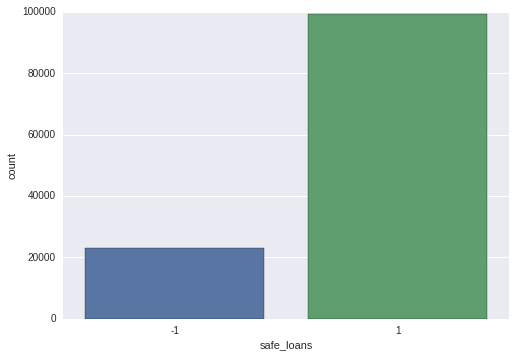

In [259]:
sns.countplot(x="safe_loans", data=loans)    

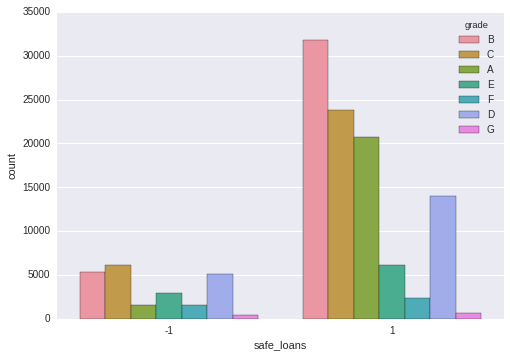

In [260]:
# Show value counts for two categorical variables:
# We can see that most of the safe loans are grade B, C or A, followed by D
sns.countplot(x="safe_loans", hue="grade", data=loans)  

In [261]:
# loans['safe_loans'].show(view = 'Categorical')

You should have:
* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

**5.** In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [262]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]] #wrap target inside [] to create list on the fly

This **subset of features** and the respnse or **target** is what we will use for the rest of this notebook. 

If you are using SFrame, proceed to the section "Sample data to balance classes".

If you are NOT using SFrame, download the list of indices for the training and validation sets: module-5-assignment-1-train-idx.json, module-5-assignment-1-validation-idx.json. Then follow the following steps:

*    Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. Alternatively, see #7 for implementation hints.
*    Load the JSON files into the lists train_idx and validation_idx.
*    Perform train/validation split using train_idx and validation_idx. In Pandas, for instance:

# One-hot encoding

**7.** For scikit-learn's decision tree implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding. The next assignment has more details about this.

If you are using SFrame, feel free to use this piece of code as is. Refer to the SFrame API documentation for a deeper understanding. If you are using different machine learning software, make sure you prepare the data to be passed to the learning software. We can't use this as it sframe specific; we will try use label encoding as suggested [here](https://www.datacamp.com/community/open-courses/introduction-to-python-machine-learning-with-analytics-vidhya-hackathons)

## Label categories to number

**Library "Scikit Learn" only works with numeric array!!** Hence, we need to label all the character variables into a numeric array. For example Variable "Gender" in any dataset usually has two labels "Male" and "Female". Hence, we  transform the labels to number as 1 for "Male" and 0 for "Female".

**"Scikit Learn"** library has a module called **"LabelEncoder"** which helps to label character labels into numbers so first import module "LabelEncoder".

from sklearn.preprocessing import LabelEncoder

number = LabelEncoder()

loans['Gender'] = number.fit_transform(loans['Gender'].astype(str))

Similarly for categorical variable named "Married", perform Label encoding for categories of variable "Married" and save it as a new variable "Married_new" in the DataFrame

loans['Married_new'] = number.fit_transform(loans['Married'].astype(str))

In [263]:
''' ###SFrame specific piece of code for one-hot encoding###
categorical_variables = []
for feature_name, feature_type in zip(loans_data.column_names(), loans_data.column_types()):
    if feature_type == str:
        categorical_variables.append(feature_name)

for feature in categorical_variables:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)

    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

loans_data.head(10)
'''

" ###SFrame specific piece of code for one-hot encoding###\ncategorical_variables = []\nfor feature_name, feature_type in zip(loans_data.column_names(), loans_data.column_types()):\n    if feature_type == str:\n        categorical_variables.append(feature_name)\n\nfor feature in categorical_variables:\n    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})\n    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)\n\n    # Change None's to 0's\n    for column in loans_data_unpacked.column_names():\n        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)\n\n    loans_data.remove_column(feature)\n    loans_data.add_columns(loans_data_unpacked)\n\nloans_data.head(10)\n"

In [264]:
print loans.columns
print "Number of features including target ", len(loans.columns)
loans.dtypes

Index([u'grade', u'sub_grade', u'short_emp', u'emp_length_num',
       u'home_ownership', u'dti', u'purpose', u'term', u'last_delinq_none',
       u'last_major_derog_none', u'revol_util', u'total_rec_late_fee',
       u'safe_loans'],
      dtype='object')
Number of features including target  13


grade                     object
sub_grade                 object
short_emp                  int64
emp_length_num             int64
home_ownership            object
dti                      float64
purpose                   object
term                      object
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
safe_loans                 int64
dtype: object

In [265]:
loans.head(5)

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.00,-1
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00,1
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97,1
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00,1


In [266]:
# Identify categorical and continuous variables
# apparently features with dtype "object" are categorical variables
# also obvious from looking at data in those columns above

target_col = ["safe_loans"]
categorical_cols = ['grade','sub_grade','home_ownership','purpose','term']

# create a list of numeric columns only - call it num_cols
# by listing all column names - then removing categorical and target from it
numeric_cols= list(  set(list(loans.columns)) - set(categorical_cols) - set(target_col) )
print len(loans.columns)
print target_col
print categorical_cols, len(categorical_cols)
print numeric_cols, len(numeric_cols)
print "We have %d actual features" %( len(categorical_cols)+ len(numeric_cols))

13
['safe_loans']
['grade', 'sub_grade', 'home_ownership', 'purpose', 'term'] 5
['dti', 'emp_length_num', 'revol_util', 'total_rec_late_fee', 'short_emp', 'last_major_derog_none', 'last_delinq_none'] 7
We have 12 actual features


In [267]:
'''
# convert all categorical/"object" data type to numeric labels
from sklearn.preprocessing import LabelEncoder

#create label encoders for categorical features
for feature in categorical_cols:
    number = LabelEncoder() #different number object for each cat var
    loans[feature] = number.fit_transform(loans[feature].astype('str'))
    
'''

for feature in categorical_cols:
    # Get one hot encoding of column feature
    one_hot = pd.get_dummies(loans[feature])
    
    # Drop column B as it is now encoded
    loans = loans.drop(feature, axis=1)
    
    # Join the encoded df
    loans = loans.join(one_hot)

In [268]:
print loans.dtypes
loans.head(5)
# Note that all categorical columns now are coded as numeric 

short_emp                  int64
emp_length_num             int64
dti                      float64
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
safe_loans                 int64
A                        float64
B                        float64
C                        float64
D                        float64
E                        float64
F                        float64
G                        float64
A1                       float64
A2                       float64
A3                       float64
A4                       float64
A5                       float64
B1                       float64
B2                       float64
B3                       float64
B4                       float64
B5                       float64
C1                       float64
C2                       float64
C3                       float64
C4                       float64
C5                       float64
          

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,A,B,...,house,major_purchase,medical,moving,other,small_business,vacation,wedding,36 months,60 months
0,0,11,27.65,1,1,83.7,0.00,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,1.00,1,1,9.4,0.00,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,11,8.72,1,1,98.5,0.00,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,11,20.00,0,1,21.0,16.97,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,4,11.20,1,1,28.3,0.00,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Sample data to balance classes

**6.** As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

In [269]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print "Number of safe loans  : %s" % len(safe_loans_raw)
print "Number of risky loans : %s" % len(risky_loans_raw)
print "Total number of loans : %s" % len(loans)

Number of safe loans  : 99457
Number of risky loans : 23150
Total number of loans : 122607


Now, write some code to compute below the percentage of safe and risky loans in the dataset and validate these numbers against what was given using `.show` earlier in the assignment:

In [270]:
print "Percentage of safe loans  :", len(safe_loans_raw)/len(loans) *100
print "Percentage of risky loans :", len(risky_loans_raw)/len(loans) *100

Percentage of safe loans  : 81.1185331996
Percentage of risky loans : 18.8814668004


One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `seed=1` so everyone gets the same results.

In [271]:
'''
# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
import random

percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
print percentage

risky_loans = risky_loans_raw
#safe_loans = safe_loans_raw.sample(percentage, seed=1)  #with graphlab

# with pandas use random.sample() method to 1st get random sample row indices
# we grab only as many  safe_loans as there are riskey_loans from entire safe_loans set
# so build a random list of row indices, size len(risky_loans_raw) 
rows = random.sample(safe_loans_raw.index, len(risky_loans_raw))

#then grab rows from safe_loans_raw with these row indices
safe_loans = safe_loans_raw.ix[rows]
# df_90 = safe_loans_raw.drop(rows)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

'''

'\n# Since there are fewer risky loans than safe loans, find the ratio of the sizes\n# and use that percentage to undersample the safe loans.\nimport random\n\npercentage = len(risky_loans_raw)/float(len(safe_loans_raw))\nprint percentage\n\nrisky_loans = risky_loans_raw\n#safe_loans = safe_loans_raw.sample(percentage, seed=1)  #with graphlab\n\n# with pandas use random.sample() method to 1st get random sample row indices\n# we grab only as many  safe_loans as there are riskey_loans from entire safe_loans set\n# so build a random list of row indices, size len(risky_loans_raw) \nrows = random.sample(safe_loans_raw.index, len(risky_loans_raw))\n\n#then grab rows from safe_loans_raw with these row indices\nsafe_loans = safe_loans_raw.ix[rows]\n# df_90 = safe_loans_raw.drop(rows)\n\n# Append the risky_loans with the downsampled version of safe_loans\nloans_data = risky_loans.append(safe_loans)\n\n'

Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%. Its going to be exactly 50% each because we sampled as many safe_loans as there are risky loans.

In [272]:
#print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)) 
#print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
#print "Total number of loans in our new dataset :", len(loans_data)
# with graphlab got these numbers
#Percentage of safe loans                 : 0.502236174422
#Percentage of risky loans                : 0.497763825578
#Total number of loans in our new dataset : 46508

**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

We had saved new dataframe as loans_data because we are not required to handle class imbalance when using sklearn, so we just go ahead and split loans dataframe into train and validate sets now.

## Split data into training and validation sets

**8.** We split the data into training and validation sets using an 80/20 split and specifying `seed=1` so everyone gets the same results.

**Note**: In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [273]:
#train_data, validation_data = loans_data.random_split(.8, seed=1)

import json
with open('module-5-assignment-1-train-idx.json', mode='r') as file1: 
    train_idx = json.load(file1)   #reads entire file in one go 

with open('module-5-assignment-1-validation-idx.json', mode='r') as file2: 
    valid_idx = json.load(file2)    #reads entire file in one go 
 
# Now we need to grab all data cols from loans 
# with row indices train_idx in train set, similar for validation set
train_data      =  loans.iloc[train_idx] 
validation_data =  loans.iloc[valid_idx]

print 'Training set   : %d data points' % len(train_data)
print 'Validation set : %d data points' % len(validation_data)

#Training set   : 37224 data points
#Validation set : 9284 data points

Training set   : 37224 data points
Validation set : 9284 data points


In [274]:
train_data.head(2)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,A,B,...,house,major_purchase,medical,moving,other,small_business,vacation,wedding,36 months,60 months
1,1,1,1.00,1,1,9.4,0.0,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0,5,5.55,1,1,32.6,0.0,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [275]:
validation_data.head(2)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,A,B,...,house,major_purchase,medical,moving,other,small_business,vacation,wedding,36 months,60 months
24,0,3,13.97,0,1,59.5,0.0,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
41,0,11,16.33,1,1,62.1,0.0,-1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0



# Use decision tree to build a classifier

**9.** Now, let's use the built-in GraphLab Create decision tree learner to create a loan prediction model on the training data. (In the next assignment, you will implement your own decision tree learning algorithm.)  Our feature columns and target column have already been decided above. Use `validation_set=None` to get the same results as everyone else.

If you are using sklearn, use the built-in scikit learn decision tree learner ([sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) to create a loan prediction model on the training data. To do this, you will need to import sklearn, sklearn.tree, and numpy.

Note: You will have to first convert the SFrame into a numpy data matrix, and extract the target labels as a numpy array (Hint: you can use the .to_numpy() method call on SFrame to turn SFrames into numpy arrays). **Don't convert pandas data frame to numpy arrays. sklearn works with pd frames, but sframes u have to convert.** See the [API](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more information. Make sure to set max_depth=6.

Call this model decision_tree_model.

In [276]:
#decision_tree_model = gl.decision_tree_classifier.create(train_data, validation_set=None,
#                                target = target, features = features)

In [277]:
response_train = train_data['safe_loans']             
response_valid = validation_data['safe_loans']             

feature_train_matrix = train_data.drop('safe_loans', axis=1)
feature_valid_matrix = validation_data.drop('safe_loans', axis=1)

feature_train_matrix.head(5)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,A,B,C,...,house,major_purchase,medical,moving,other,small_business,vacation,wedding,36 months,60 months
1,1,1,1.00,1,1,9.4,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0,5,5.55,1,1,32.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,1,1,18.08,1,1,36.5,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,1,1,10.08,1,1,91.7,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12,0,4,7.06,1,1,55.5,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [278]:
# from sklearn.tree import DecisionTreeClassifier
### Create Decision Tree object
# decision_tree_model  = DecisionTreeClassifier()

from sklearn import tree

# Initialize model
decision_tree_model = tree.DecisionTreeClassifier(max_depth=6)

# Train the model
decision_tree_model.fit(X = feature_train_matrix, y = response_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Visualizing a learned model

Once trained, we can export the tree in [Graphviz](http://www.graphviz.org/) format using the [export_graphviz](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz) exporter. Below is an example export of a tree trained above. see [this](http://nbviewer.jupyter.org/github/kittipatkampa/python_dev/blob/master/demo_decision_tree_v1.ipynb) also  [this](http://scikit-learn.org/stable/modules/tree.html)

In [279]:
from sklearn.externals.six import StringIO

with open("dot_data.dot", 'w') as f:
    f = tree.export_graphviz(decision_tree_model, out_file=f)

Then we can use Graphviz’s dot tool to create a PDF file (or any other supported file type): 

[vinorda@hp450 Week3]$ ls -ltr

-rwxrwxrwx. 1 root root    10265 Sep 28 07:53 dot_data.dot

-rwxrwxrwx. 1 root root    26962 Sep 28 07:53 dot_data.pdf

[vinorda@hp450 Week3]$ dot -Tpdf dot_data.dot -o decision_tree_model.pdf

opened decision_tree_model.pdf in reader - worked without any issues with irs dataset.

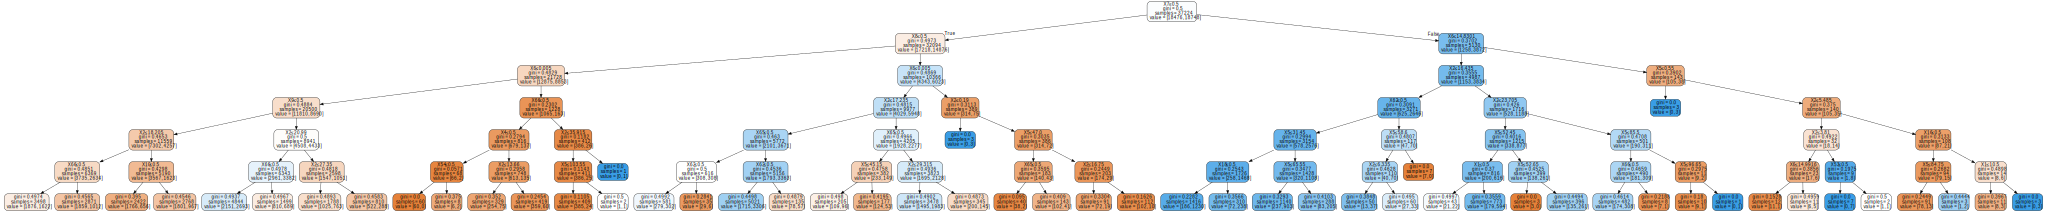

In [280]:
from sklearn.tree import export_graphviz
import graphviz
#small_model.show(view="Tree")
export_graphviz(decision_tree_model, out_file="decision_tree.dot",   #out_file=dot_data
                         #feature_names=['Sex'],   
                         #class_names=target,  
                         filled=True, rounded=True,  
                         special_characters=True)  

with open("decision_tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

**10.** As noted in the [documentation](https://dato.com/products/create/docs/generated/gl.boosted_trees_classifier.create.html#gl.boosted_trees_classifier.create), typically the max depth of the tree is capped at 6. However, such a tree can be hard to visualize graphically.  Here, we instead learn a smaller model with **max depth of 2** to gain some intuition by visualizing the learned tree.

In [281]:
# Initialize model
small_model = tree.DecisionTreeClassifier(max_depth=2)

# Train the model
small_model.fit(X = feature_train_matrix, y = response_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In the view that is provided by GraphLab Create, you can see each node, and each split at each node. This visualization is great for considering what happens when this model predicts the target of a new data point.  (If you are using scikit-learn and have the package [Graphviz](http://graphviz.readthedocs.org/en/latest/#), then you will be able to perform this section.)

**Note:** To better understand this visual:
* The root node is represented using pink. 
* Intermediate nodes are in green. 
* Leaf nodes in blue and orange. 

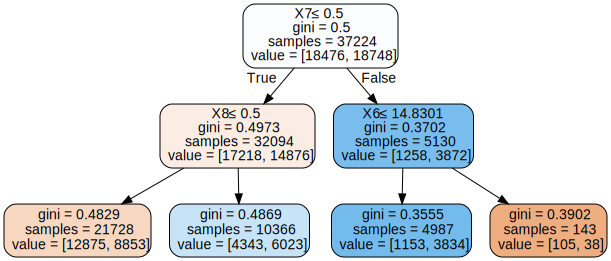

In [282]:
from sklearn.tree import export_graphviz
import graphviz
#small_model.show(view="Tree")
export_graphviz(small_model, out_file="decision_tree.dot",   #out_file=dot_data
                         #feature_names=['Sex'],   
                         #class_names=target,  
                         filled=True, rounded=True,  
                         special_characters=True)  

with open("decision_tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

**11.** First, let's grab 2 positive examples and 2 negative examples. In SFrame, that would be:

In [283]:
#response_train = train_data['safe_loans']             
#response_valid = validation_data['safe_loans']             
#feature_train_matrix = train_data.drop('safe_loans', axis=1)
#feature_valid_matrix = validation_data.drop('safe_loans', axis=1)

validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_safe = validation_safe_loans[0:2]
sample_validation_data_risky = validation_risky_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data_response = sample_validation_data['safe_loans']
sample_validation_data = sample_validation_data.drop('safe_loans', axis=1)

## Explore label predictions

**12.** Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. 

**Hint:** Be sure to use the `.predict()` method.

In [284]:
predictions = decision_tree_model.predict(sample_validation_data)
print predictions
print sample_validation_data_response

[ 1 -1 -1  1]
19    1
79    1
24   -1
41   -1
Name: safe_loans, dtype: int64


**Quiz Question:** What percentage of the predictions on `sample_validation_data` did `decision_tree_model` get correct?
* predictions [1, -1, -1, 1]  actual      [1, 1, -1, -1] got 2 out of 4 right , 50%

In [285]:
print "num of predictions +ve class:%d" %(predictions == +1).sum()
print "num of predictions -ve class:%d" %(predictions == -1).sum()
actuals = sample_validation_data_response
num_correct = sum( np.equal(predictions, actuals))
num_mistakes = len(sample_validation_data) - num_correct
accuracy = num_correct/len(sample_validation_data)
print "-----------------------------------------------------"
print '# Reviews   correctly classified =', num_correct
print '# Reviews incorrectly classified =', num_mistakes
print '# Reviews total                  =', len(sample_validation_data)
print "-----------------------------------------------------"
print 'Accuracy = %.2f' % accuracy

num of predictions +ve class:2
num of predictions -ve class:2
-----------------------------------------------------
# Reviews   correctly classified = 2
# Reviews incorrectly classified = 2
# Reviews total                  = 4
-----------------------------------------------------
Accuracy = 0.50


## Explore probability predictions

**13.** For each row in the **sample_validation_data**, what is the probability (according **decision_tree_model**) of a loan being classified as **safe**? 


**Hint:** Set `output_type='probability'` to make **probability** predictions using **decision_tree_model** on `sample_validation_data`. If you are using scikit-learn, you can use the .predict_proba() method.

In [286]:
prob_predictions = decision_tree_model.predict_proba(sample_validation_data)
#prob_predictions = prob_predictions.to_numpy()
#print "Probs %0.4f" %prob_predictions
print prob_predictions
print prob_predictions[:,1] #2nd col is prob(safe_loan = +ve) class

[[ 0.34156543  0.65843457]
 [ 0.53630646  0.46369354]
 [ 0.64750958  0.35249042]
 [ 0.20789474  0.79210526]]
[ 0.65843457  0.46369354  0.35249042  0.79210526]


In [287]:
max_prob, index = max([(v,i) for i,v in enumerate(prob_predictions[:,1])])
print "Highest probabilty = %0.4f for item at index %d" %(max_prob, index)

#sample_validation_data.iloc[index]

Highest probabilty = 0.7921 for item at index 3


In [288]:
#prob_predictions = prob_predictions.to_numpy()
#max_value = max(prob_predictions)
#max_index = prob_predictions.index(max_value)
#print "Highest probabilty = %0.2f for item at index %d" %(max_value, max_index)
#'numpy.ndarray' and 'SArray' object object has no attribute 'index'

In [289]:
#max([(v,i) for i,v in enumerate(prob_predictions)])
#print "Highest probabilty = %0.2f for item at index %d" %(v, prob_predictions.index(i))
#'numpy.ndarray' and 'SArray' object object has no attribute 'index'

**Quiz Question:** Which loan has the highest probability of being classified as a **safe loan**?

The 4th loan (index = 3) although this is actually an unsafe loan!!.

**Checkpoint:** Can you verify that for all the predictions with `probability >= 0.5`, the model predicted the label **+1**?

In [290]:
prob_2_class = [+1 if x >= 0.5 else -1 for x in prob_predictions[:,1]]  
print prob_predictions[:,1]
print prob_2_class
print "Number matching ", sum( np.equal(predictions, prob_2_class))

[ 0.65843457  0.46369354  0.35249042  0.79210526]
[1, -1, -1, 1]
Number matching  4


### Tricky predictions!

**14.** Now, we will explore something pretty interesting. For each row in the **sample_validation_data**, what is the probability (according to **small_model**) of a loan being classified as **safe**?

**Hint:** Set `output_type='probability'` to make **probability** predictions using **small_model** on `sample_validation_data`:

In [291]:
prob_predictions_small = small_model.predict_proba(sample_validation_data)
print prob_predictions_small[:,1]
print "\n", sample_validation_data.head()

[ 0.58103415  0.40744661  0.40744661  0.76879888]

    short_emp  emp_length_num    dti  last_delinq_none  last_major_derog_none  \
19          0              11  11.18                 1                      1   
79          0              10  16.85                 1                      1   
24          0               3  13.97                 0                      1   
41          0              11  16.33                 1                      1   

    revol_util  total_rec_late_fee    A    B    C     ...      house  \
19        82.4                 0.0  0.0  1.0  0.0     ...        0.0   
79        96.4                 0.0  0.0  0.0  0.0     ...        0.0   
24        59.5                 0.0  0.0  0.0  0.0     ...        0.0   
41        62.1                 0.0  1.0  0.0  0.0     ...        0.0   

    major_purchase  medical  moving  other  small_business  vacation  wedding  \
19             0.0      0.0     0.0    0.0             0.0       0.0      0.0   
79             0.0  

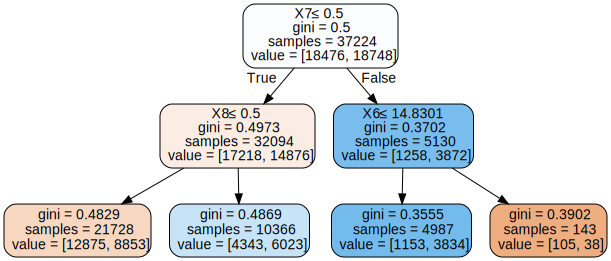

In [292]:
graphviz.Source(dot_graph)

In [293]:
#sample_validation_data['X7','X6','X8'].head()
#sample_validation_data['A','B','D'].head()
#feature_train_matrix.head()
sample_validation_data.columns

Index([u'short_emp', u'emp_length_num', u'dti', u'last_delinq_none',
       u'last_major_derog_none', u'revol_util', u'total_rec_late_fee', u'A',
       u'B', u'C', u'D', u'E', u'F', u'G', u'A1', u'A2', u'A3', u'A4', u'A5',
       u'B1', u'B2', u'B3', u'B4', u'B5', u'C1', u'C2', u'C3', u'C4', u'C5',
       u'D1', u'D2', u'D3', u'D4', u'D5', u'E1', u'E2', u'E3', u'E4', u'E5',
       u'F1', u'F2', u'F3', u'F4', u'F5', u'G1', u'G2', u'G3', u'G4', u'G5',
       u'MORTGAGE', u'OTHER', u'OWN', u'RENT', u'car', u'credit_card',
       u'debt_consolidation', u'home_improvement', u'house', u'major_purchase',
       u'medical', u'moving', u'other', u'small_business', u'vacation',
       u'wedding', u' 36 months', u' 60 months'],
      dtype='object')

In [294]:
#feature_valid_matrix = validation_data.drop('safe_loans', axis=1)
feature_valid_matrix.columns

Index([u'short_emp', u'emp_length_num', u'dti', u'last_delinq_none',
       u'last_major_derog_none', u'revol_util', u'total_rec_late_fee', u'A',
       u'B', u'C', u'D', u'E', u'F', u'G', u'A1', u'A2', u'A3', u'A4', u'A5',
       u'B1', u'B2', u'B3', u'B4', u'B5', u'C1', u'C2', u'C3', u'C4', u'C5',
       u'D1', u'D2', u'D3', u'D4', u'D5', u'E1', u'E2', u'E3', u'E4', u'E5',
       u'F1', u'F2', u'F3', u'F4', u'F5', u'G1', u'G2', u'G3', u'G4', u'G5',
       u'MORTGAGE', u'OTHER', u'OWN', u'RENT', u'car', u'credit_card',
       u'debt_consolidation', u'home_improvement', u'house', u'major_purchase',
       u'medical', u'moving', u'other', u'small_business', u'vacation',
       u'wedding', u' 36 months', u' 60 months'],
      dtype='object')

In [295]:
set(sample_validation_data.columns) == set(feature_valid_matrix.columns)

True

sample_validation_data.columns and feature_train_matrix.columns contain the same columns (as they should!!) but where is features X6,X7 or X8?????

**Quiz Question:** Notice that the probability preditions are the **exact same** for the 2nd and 3rd loans. Why would this happen? Not so when using sklearn.

So reason why both loans have same prob prediction is 
“During tree traversal both examples fall into the same leaf node.”  

This is solution based on graphlab grown tree. The tree growing algorithm usually decides on a varibale to split on by checking which split results in most pure nodes. So it picked feature="grade==A" to split on at base/1st decision/split of tree. Even at 2nd level split decision, it again chose "grade==B". So since both 2nd and 3rd loan were D grade loans, they got binned together and got same prediction as bad loans, even though in actual fact 2nd loan was safe_loan.

## Visualize the prediction on a tree


**14a.** Note that you should be able to look at the small tree (of depth 2), traverse it yourself, and visualize the prediction being made. Consider the following point in the **sample_validation_data**

In [296]:
sample_validation_data[1:3]   #inspect the 2nd and 3rd samples

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,A,B,C,...,house,major_purchase,medical,moving,other,small_business,vacation,wedding,36 months,60 months
79,0,10,16.85,1,1,96.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24,0,3,13.97,0,1,59.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Let's visualize the small tree here to do the traversing for this data point.

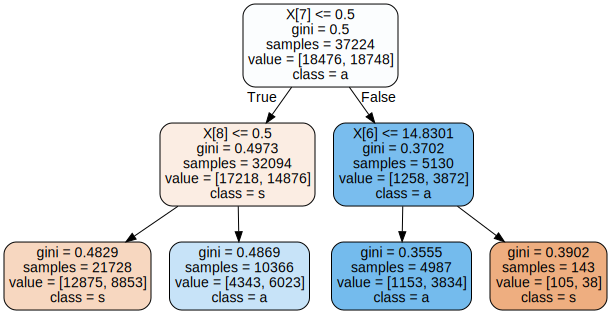

In [297]:
# Initialize model
small_model = tree.DecisionTreeClassifier(max_depth=2)

# Train the model
small_model.fit(X = feature_train_matrix, y = response_train)

#small_model.show(view="Tree")
export_graphviz(small_model, out_file="mytree.dot",   #out_file=dot_data
                         #feature_names=features,
                         class_names= target,
                         #class_names=['risky','safe']) 
                         filled=True, rounded=True) 
                         #special_characters=True)  

with open("mytree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

**Note: for graphlab tree plot** In the tree visualization above, the values at the leaf nodes are not class predictions but scores (a slightly advanced concept that is out of the scope of this course). You can read more about this [here](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf).  If the score is $\geq$ 0, the class +1 is predicted.  Otherwise, if the score < 0, we predict class -1.


**Quiz Question:** Based on the visualized tree, what prediction would you make for this data point?

The sub-grade of loan is 15. Now follow the tree from top, 
* 1st split decision  sub_grade <= 8.5, False - take right branch
* 2nd split decision  sub_grade <= 15.5, Yes - so take left branch - leads to leaf node has 13010 sample, 6773 safe, 6273 risky
* majority vote safe, we predict class +1 (safe loan)

**15.** Now, let's verify your prediction by examining the prediction made using sklearn.  Use the `.predict_proba()` function on `small_model`.

We see that model (below) predicts it as risky loan, class -1, prob +ve = 0.407

In [298]:
#prob_predictions_small = small_model.predict(sample_validation_data[1],output_type='class')
#print prob_predictions_small  
#print sample_validation_data[1]['safe_loans']
#-1
#1
class_predictions_small = small_model.predict(sample_validation_data[1:2])
prob_predictions_small = small_model.predict_proba(sample_validation_data[1:2])
print class_predictions_small
print prob_predictions_small[:,1]

[-1]
[ 0.40744661]


In [299]:
sample_validation_data[1:2]

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,A,B,C,...,house,major_purchase,medical,moving,other,small_business,vacation,wedding,36 months,60 months
79,0,10,16.85,1,1,96.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

**16.** Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

In [300]:
from sklearn.metrics import accuracy_score

small_predictions = small_model.predict(feature_train_matrix)
# accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
print round(accuracy_score(response_train, small_predictions),2)

#print small_predictions[0:5]
#print (sample_validation_data['safe_loans'][0:5]).as_matrix()

big_predictions = decision_tree_model.predict(feature_train_matrix)
# accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
print "\n",round(accuracy_score(response_train,big_predictions),2)

0.61

0.64


**Checkpoint:** You should see that the **small_model** (accuracy 61%) performs worse than the **decision_tree_model** (accuracy 64%)  on the training data.


**17.** Now, let us evaluate the accuracy of the **small_model** and **decision_tree_model** on the entire **validation_data**, not just the subsample considered above.

In [301]:
small_predictions = small_model.predict(feature_valid_matrix)
# accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
print round(accuracy_score(response_valid, small_predictions),2)

#print small_predictions[0:5]
#print (sample_validation_data['safe_loans'][0:5]).as_matrix()

big_predictions = decision_tree_model.predict(feature_valid_matrix)
# accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
print "\n",round(accuracy_score(response_valid,big_predictions),2)

0.62

0.64


**Quiz Question:** What is the accuracy of `decision_tree_model` on the validation set, rounded to the nearest .01?
0.63

## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

**18.** If using sklearn, use sklearn.tree.DecisionTreeClassifier to train a decision tree with maximum depth = 10. Call this model big_model.

In [302]:
#big_model = gl.decision_tree_classifier.create(train_data, validation_set=None,
#                   target = target, features = features, max_depth = 10)

# Initialize model
big_model = tree.DecisionTreeClassifier(max_depth=10)

# Train the model
big_model.fit(X = feature_train_matrix, y = response_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

**19.** Now, let us evaluate **big_model** on the training set and validation set.

In [303]:
big_model_train = big_model.predict(feature_train_matrix)
# accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
print "\n",round(accuracy_score(response_train,big_model_train),2)


big_model_valid = big_model.predict(feature_valid_matrix)
# accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
print "\n",round(accuracy_score(response_valid,big_model_valid),2)


0.66

0.63


**Checkpoint:** We should see that **big_model** has even better performance on the training set (66%) than **decision_tree_model** did on the training set (64%).

**Quiz Question:** How does the performance of **big_model** on the validation set (63%) compare to **decision_tree_model** on the validation set (64%)? Is this a sign of overfitting?  Big Model has worse performance (accuracy 63%) on validation set. Simpler **decision_tree_model** has similar accuracy - 64% - just a bit higher. Shows that a complex model that overfits training data (i.e small error on training data - see high accuracy 66%, due low bias) doesn't generallise well and may often perform poorly than simpler models on test/validation data.

### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

First, let us make predictions on `validation_data` using the `decision_tree_model`:

In [304]:
predictions = decision_tree_model.predict(feature_valid_matrix)
#true_labels = validation_data['safe_loans']
true_labels = response_valid

**False positives** are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives:

In [305]:
#[1 if (x == 1 and y == -1) else 0 for x,y in enumerate(predictions, actuals)]

#TypeError: 'SArray' object cannot be interpreted as an index

false_positives = sum((predictions == +1) & (true_labels == -1))
false_positives

1661

**False negatives** are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

In [306]:
false_negatives = sum((predictions == -1) & (true_labels == +1))
false_negatives

1715

**Quiz Question:** Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

What is the total cost of mistakes made by `decision_tree_model` on `validation_data`?

In [307]:
total_cost = 10000 * false_negatives + 20000 * false_positives
print "Total_cost for wrong predictions: $%.2f" %total_cost 

Total_cost for wrong predictions: $50370000.00
